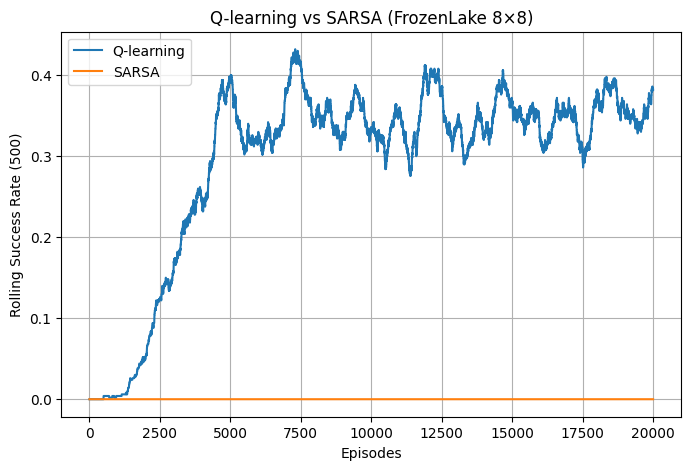

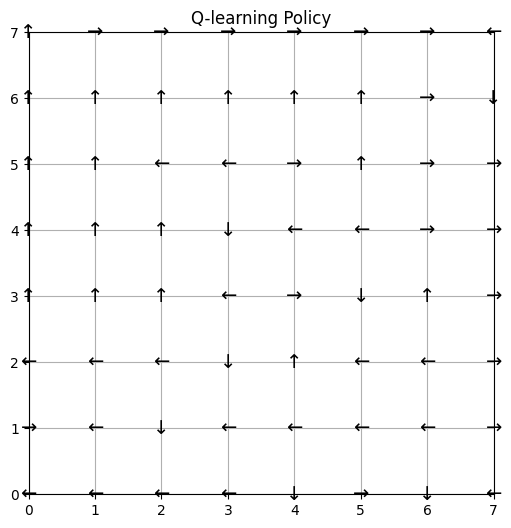

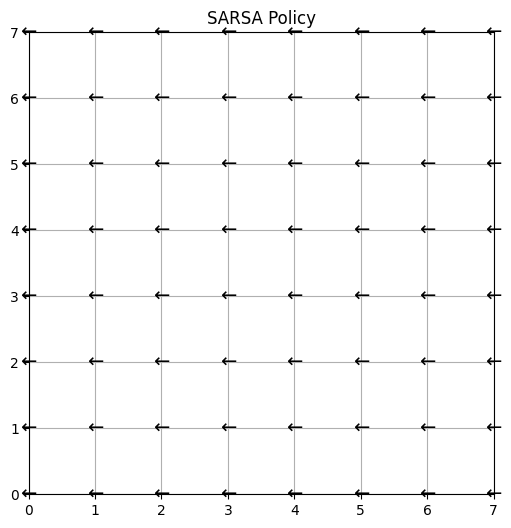

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Environment setup
# -----------------------------
env = gym.make(
    "FrozenLake-v1",
    map_name="8x8",
    is_slippery=True
)

n_states = env.observation_space.n
n_actions = env.action_space.n
grid_size = int(np.sqrt(n_states))

# -----------------------------
# Shared hyperparameters
# -----------------------------
ALPHA = 0.1
GAMMA = 0.99
EPSILON = 1.0
EPSILON_MIN = 0.1
EPSILON_DECAY = 0.9995
NUM_EPISODES = 20000
MAX_STEPS = 200
WINDOW = 500

# -----------------------------
# ε-greedy policy
# -----------------------------
def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    return np.argmax(Q[state])

# -----------------------------
# Q-learning (off-policy)
# -----------------------------
def train_q_learning():
    Q = np.zeros((n_states, n_actions))
    rewards, success_rate = [], []
    successes = []

    epsilon = EPSILON

    for ep in range(NUM_EPISODES):
        state, _ = env.reset()
        done = False
        ep_reward = 0
        success = 0

        for _ in range(MAX_STEPS):
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            Q[state, action] += ALPHA * (
                reward + GAMMA * np.max(Q[next_state]) - Q[state, action]
            )

            state = next_state
            ep_reward += reward

            if done:
                if reward == 1:
                    success = 1
                break

        rewards.append(ep_reward)
        successes.append(success)

        epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

        if len(successes) >= WINDOW:
            success_rate.append(np.mean(successes[-WINDOW:]))
        else:
            success_rate.append(0.0)

    return Q, rewards, success_rate

# -----------------------------
# SARSA (on-policy)
# -----------------------------
def train_sarsa():
    Q = np.zeros((n_states, n_actions))
    rewards, success_rate = [], []
    successes = []

    epsilon = EPSILON

    for ep in range(NUM_EPISODES):
        state, _ = env.reset()
        action = epsilon_greedy(Q, state, epsilon)
        done = False
        ep_reward = 0
        success = 0

        for _ in range(MAX_STEPS):
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_action = epsilon_greedy(Q, next_state, epsilon)

            Q[state, action] += ALPHA * (
                reward + GAMMA * Q[next_state, next_action] - Q[state, action]
            )

            state, action = next_state, next_action
            ep_reward += reward

            if done:
                if reward == 1:
                    success = 1
                break

        rewards.append(ep_reward)
        successes.append(success)

        epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

        if len(successes) >= WINDOW:
            success_rate.append(np.mean(successes[-WINDOW:]))
        else:
            success_rate.append(0.0)

    return Q, rewards, success_rate

# -----------------------------
# Train both agents
# -----------------------------
Q_q, rewards_q, sr_q = train_q_learning()
Q_s, rewards_s, sr_s = train_sarsa()

# -----------------------------
# Plot success rate comparison
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(sr_q, label="Q-learning")
plt.plot(sr_s, label="SARSA")
plt.xlabel("Episodes")
plt.ylabel("Rolling Success Rate (500)")
plt.title("Q-learning vs SARSA (FrozenLake 8×8)")
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# Extract greedy policies
# -----------------------------
policy_q = np.argmax(Q_q, axis=1)
policy_s = np.argmax(Q_s, axis=1)

# -----------------------------
# Policy visualization
# -----------------------------
action_map = {0: '←', 1: '↓', 2: '→', 3: '↑'}

def plot_policy(policy, title):
    grid = policy.reshape(grid_size, grid_size)
    plt.figure(figsize=(6, 6))
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, grid_size - i - 1, action_map[grid[i, j]],
                     ha='center', va='center', fontsize=14)
    plt.xticks(range(grid_size))
    plt.yticks(range(grid_size))
    plt.grid()
    plt.title(title)
    plt.show()

plot_policy(policy_q, "Q-learning Policy")
plot_policy(policy_s, "SARSA Policy")

env.close()
